In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchinfo import summary

import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "src")))
import dataset
from models import FSRCNN
import metrics

# %load_ext autoreload
# %autoreload 2

In [5]:
ds = dataset.load_general100_dataset()
img_arr = [img["image"] for img in ds["train"]]

In [3]:
# img_sample = img_arr[0:150]  # Sample 10 images for training
# args_augment_fsrcnn = [[0.8, 0.6], [180]]
# args_patches_fsrcnn = [upsample_factor, 100, 5, True]

# args_dataloaders = {
#     "batch_size": 128,
#     "num_workers": 0,
#     "seed": 42,
#     "val_split": 0.2
# }
# train_loader, val_loader = dataset.prepare_to_train(img_sample, args_augment_fsrcnn, args_patches_fsrcnn, args_dataloaders)

In [ ]:
# Paso 1: Convertir imágenes PIL a arrays BGR (formato OpenCV)
img_sample = img_arr[0:150]
img_sample_cv2 = [dataset.pil_to_cv2(img) for img in img_sample]

# Paso 2: Augmentación con escalado y rotación usando OpenCV
args_augment_fsrcnn = [[0.9, 0.8, 0.7], [90, 180, 270]]
augmented_images_cv2 = dataset.augment_data_cv2(img_sample_cv2, *args_augment_fsrcnn)

# Paso 3: Parámetros para generación de parches lazy
upsample_factor = 2
patch_size = 10
stride = 5
use_deconv = True

# Paso 4: DataLoaders con LazyPatchDatasetCV2
train_loader, val_loader = dataset.lazy_train_val_dataloaders_cv2(
    images=augmented_images_cv2,
    scale_factor=upsample_factor,
    patch_size=patch_size,
    stride=stride,
    use_deconv=use_deconv,
    batch_size=512,
    num_workers=6,
    seed=42,
    val_split=0.2
)

Lazy CV2 Dataset Statistics:

Total samples: 2261956
Training examples: 1809565
Validation examples: 452391
Batch size: 512


In [31]:
from torch.amp import autocast, GradScaler

def train_sr_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    scaler = GradScaler('cuda')
    train_loss = []
    valid_loss = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            lr_batch, hr_batch = batch
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                sr_batch = model(lr_batch)
                loss = criterion(sr_batch, hr_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.6f}")
        train_loss.append(avg_train_loss)

        # VALIDACIÓN
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_loader:
                lr_val, hr_val = val_batch
                lr_val, hr_val = lr_val.to(device), hr_val.to(device)
                with autocast('cuda'):
                    sr_val = model(lr_val)
                    loss = criterion(sr_val, hr_val)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.6f}")
        valid_loss.append(avg_val_loss)

    return train_loss, valid_loss

In [8]:
upsample_factor = 2
patch_size = 10
model = FSRCNN(upsample_factor=upsample_factor)
print(summary(model, input_size=(1, 1, patch_size, patch_size)))

Layer (type:depth-idx)                   Output Shape              Param #
FSRCNN                                   [1, 1, 20, 20]            --
├─Sequential: 1-1                        [1, 56, 10, 10]           --
│    └─Conv2d: 2-1                       [1, 56, 10, 10]           1,456
│    └─PReLU: 2-2                        [1, 56, 10, 10]           56
├─Sequential: 1-2                        [1, 12, 10, 10]           --
│    └─Conv2d: 2-3                       [1, 12, 10, 10]           684
│    └─PReLU: 2-4                        [1, 12, 10, 10]           12
├─Sequential: 1-3                        [1, 12, 10, 10]           --
│    └─Conv2d: 2-5                       [1, 12, 10, 10]           1,308
│    └─PReLU: 2-6                        [1, 12, 10, 10]           12
│    └─Conv2d: 2-7                       [1, 12, 10, 10]           1,308
│    └─PReLU: 2-8                        [1, 12, 10, 10]           12
│    └─Conv2d: 2-9                       [1, 12, 10, 10]           1,308
│ 

In [ ]:
train_loss, val_loss = train_sr_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4)
torch.save(model.state_dict(), "fsrcnn_model.pth")

Using device: cuda


Epoch 1/10 - Training: 100%|██████████| 3535/3535 [02:54<00:00, 20.27it/s]


[Epoch 1] Train Loss: 0.010830
[Epoch 1] Val Loss: 0.003297


Epoch 2/10 - Training: 100%|██████████| 3535/3535 [02:41<00:00, 21.93it/s]


[Epoch 2] Train Loss: 0.002674
[Epoch 2] Val Loss: 0.002307


Epoch 3/10 - Training: 100%|██████████| 3535/3535 [02:37<00:00, 22.40it/s]


[Epoch 3] Train Loss: 0.002192
[Epoch 3] Val Loss: 0.002102


Epoch 4/10 - Training: 100%|██████████| 3535/3535 [02:42<00:00, 21.77it/s]


[Epoch 4] Train Loss: 0.002056
[Epoch 4] Val Loss: 0.002013


Epoch 5/10 - Training: 100%|██████████| 3535/3535 [02:42<00:00, 21.76it/s]


[Epoch 5] Train Loss: 0.002005


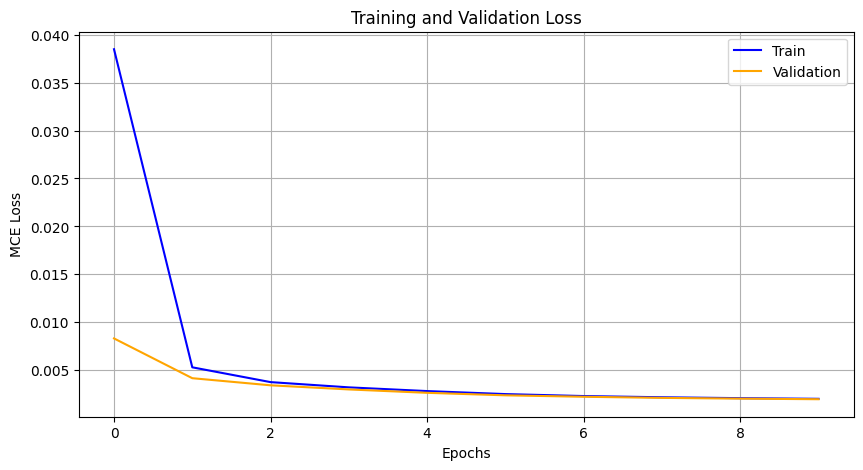

In [ ]:
## plot the train loss and validation loss evolution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train', color='blue')
plt.plot(val_loss, label='Validation', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MCE Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import json

history = {
    "train_loss": train_loss,
    "val_loss": val_loss
}

with open("FSRCNN_losses.json", "w") as f:
    json.dump(history, f)

In [ ]:
model = FSRCNN(upsample_factor=2)
model.load_state_dict(torch.load("fsrcnn_model.pth"))
model.eval()

FSRCNN(
  (extraction): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (shrinking): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (mapping): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
  )
  (expansion): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4), output_padding=(1, 1))
  )
)

In [ ]:
import numpy as np
from models import get_y_tensors
import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

factor = 2
for setnum in [5, 14]:
    ds = utils.get_images(setnum, factor)
    hr_images, lr_images = zip(*ds)
    lr_tensors = get_y_tensors(lr_images)
    hr_tensors = get_y_tensors(hr_images)

    psnrs = []
    ssims = []
    for lr, hr in zip(lr_tensors, hr_tensors):
        lr = lr.to(device)
        with torch.no_grad():
            sr = model(lr).cpu().numpy().squeeze()
            hr = hr.numpy().squeeze()

        sr = np.clip(sr, 0, 1) # probablemente introduce error, hay que ver como evitarlo

        # show both images with matplotlib
        # import matplotlib.pyplot as plt
        # plt.figure(figsize=(10, 5))
        # plt.subplot(1, 2, 1)
        # plt.imshow(sr, cmap='gray')
        # plt.title('Super-Resolved Image')
        # plt.axis('off')
        # plt.subplot(1, 2, 2)
        # plt.imshow(hr, cmap='gray')
        # plt.title('High-Resolution Image')
        # plt.axis('off')
        # plt.show()
        # # print image shapes
        # print(f"Super-Resolved Image Shape: {sr.shape}, High-Resolution Image Shape: {hr.shape}")

        psnrs.append(metrics.calculate_psnr(sr, hr, data_range=1.0))
        ssims.append(metrics.calculate_ssim(sr, hr, data_range=1.0))
    print(f"Set{setnum} - PSNR: {np.mean(psnrs):.2f}, SSIM: {np.mean(ssims):.4f}")


Set5 - PSNR: 31.72, SSIM: 0.8886
Set14 - PSNR: 28.37, SSIM: 0.8236
